<a href="https://colab.research.google.com/github/infected4098/DSF-/blob/main/4visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파일 임포트 구글 드라이브 마운트 등


In [ ]:
pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
#딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from statsmodels.formula.api import ols

#전처리, 점수 측정
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#컴퓨터 리소스 할당 관련 
import os
from tqdm.auto import tqdm 

#기초 툴, 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib
from yellowbrick.cluster import KElbowVisualizer

#기타
import warnings
warnings.filterwarnings("ignore")

#크롤링 및 워드클라우드
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote 
import requests
import re
from datetime import datetime
from PIL import *
from collections import Counter
import xml.etree.ElementTree as ET
import json

#지리
import geopandas as gpd
from geopy.geocoders import Nominatim
import shapefile
import folium
from shapely.geometry import Point, Polygon, LineString


In [ ]:
#구글 드라이브 mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
#각종 경로
d_path="/content/gdrive/MyDrive/"
font_path = '/content/gdrive/MyDrive/DSF/malgun'


In [ ]:
#한글 폰트
font_name = fm.FontProperties(fname = font_path).get_name()
matplotlib.rc("font", family = font_name)
%matplotlib inline

# 장애인 예산 시각화

In [ ]:
#단위는 억 원
#자료출처: 보건복지부 기금운영계획안 사업운영계획
disabled_budget = [4679, 5221, 6061, 6907, 9685, 13057, 15070, 17405]
disabled_index = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
disabled_df = pd.DataFrame(disabled_budget, index=disabled_index, columns=["yearly_budget"])
disabled_df.head()

In [ ]:
disabled_list = [18816,
19652,
20670,
22213,
27326,
32762,
36662,
40070,

17101,
17755,
18744,
20155,
24731,
29840,
33447,
9731+20930+6541,
6931,
6911,
6927,
7306,
8495,
9180,
9664,
9731,

5496,
6130,
6973,
7902,
11065,
15107,
17704,
20930,

4673,
4715,
4845,
4947,
5171,
5553,
6079,
6541]

disabled_col = ["총계","3대 사업", "장애수당/연금", "장애인 선택적 복지", "장애인복지시설 지원"]

disabled_array = np.array(disabled_list)
disabled_array = disabled_array.reshape(5, -1)

disabled_whole = pd.DataFrame(disabled_array, index=disabled_col, columns=disabled_index)

disabled_whole = disabled_whole.T


In [ ]:
#활동지원할당 예산 증가 추세/ 단위는 억 원
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.plot(disabled_whole.index, disabled_whole["총계"],marker='s', color="black", label='Total') 
ax.bar(disabled_whole.index, disabled_whole["장애인 선택적 복지"]*100*1000/disabled_whole["총계"], color="skyblue", label='Percentage of Activity') #10^3 scaled
ax.plot(disabled_whole.index, disabled_whole["장애인 선택적 복지"], color="red", marker='o',label='Activity') 
ax.legend()
plt.title("Budget Increase on activity budget")
plt.show()


#장애인을 수동적인 대상으로 바라보는 것이 아니라 장애인이 정책 시행의 주체로서 활동할 수 있게하는 것

# 크롤링, keyword = "탈시설"

In [ ]:
#탈시설 이라는 키워드 크롤링

news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'
query = "탈시설"
news_num =3000 # 총 필요한 뉴스의 개수
req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')

news_dict = {}
idx = 0
cur_page = 1


In [ ]:
while idx < news_num:
    
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          'url' : n.get('href') }
        idx += 1

    cur_page += 1
    
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')

In [ ]:
print('데이터프레임 변환')
news_df = pd.DataFrame(news_dict).T
news_df

In [ ]:
def word_list(title):
  noun_adj_list = []

  for words in title:
    sentence_list = twitter.pos(words)
    for word, tag in sentence_list:
      if tag in ["Noun", "Adjective"]:
        noun_adj_list.append(word)
      else:
        pass
  return noun_adj_list


In [ ]:
twitter = Twitter()
sentence_list = []


noun_adj = word_list(news_df["title"])
print(noun_adj)

    




In [ ]:
counts = Counter(noun_adj)
tags = counts.most_common(50)
print(tags)

In [ ]:
#전장연 시위 관련된 단어, '장애'같은 동의어는 수작업으로 제거 
tags_dict = dict(tags)
#print(tags_dict.keys())
execute_keys = ["시설", "탈", "장연", "지하철", "탈시", "위", "시위", "중", "것"] 

useful_dict = {}
for key in tags_dict:
  if key not in execute_keys:
    useful_dict[key] = tags_dict[key]
  
print(useful_dict)

In [ ]:
wordcloud = WordCloud(
    font_path = '/content/gdrive/MyDrive/DSF/malgun', background_color='white', colormap='Reds').generate_from_frequencies(useful_dict)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off') 
plt.title("Wordcloud")


# 예산 -> 활동지원사 수 회귀분석

In [ ]:
import requests

url = 'http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api'
params = {'serviceKey' : 'P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D', 'pageNo' : '1', 'numOfRows' : '10', 'apiType' : 'XML', 'year' : '2019', 'dvsd' : '인천' }

response = requests.get(url, params=params)
print(response.content)


In [ ]:
encoding = "P17GWD3PsEYIjlKLQZhHbDp7%2FB6PK0nyG2uYMfazEiD%2BTAeBwMc6HdvyA7UBWxpt0uBzAOGSrmCNcco7E0bc%2FA%3D%3D"
year=""
region=""
def make_url(encoding, year, region):
  

  url = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + str(encoding) + "numOfRows=20&pageNo=1&apiType=JSON&year="+str(year)+"&dvsd="+str(region)
  return url



In [ ]:
url_2015 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2015&dvsd=인천"
url_2016 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2016"

url_2017 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2017"
url_2018 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2018"
url_2019 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2019"
url_2020 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2020"
url_2021 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2021"
url_2022 = "http://apis.data.go.kr/1352000/ODMS_STAT_18/callStat18Api?serviceKey=" + encoding + "&numOfRows=30&pageNo=1&apiType=JSON&year=2022"

url_list = [url_2015, url_2016, url_2017, url_2018, url_2019, url_2020, url_2021, url_2022]



In [ ]:
req = requests.get(url_2018)
req.encoding = "utf-8"
text = req.content
print(text)

In [ ]:
act_dict = {}
ems_dict = {}
n = 0
req = requests.get(url_2015)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems
print(ems_dict)

In [ ]:
n = 1
req = requests.get(url_2016)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)


In [ ]:
n = 2
req = requests.get(url_2017)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

In [ ]:
n = 3
req = requests.get(url_2018)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

In [ ]:
n = 4
req = requests.get(url_2019)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

In [ ]:
n = 5
req = requests.get(url_2020)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems

print(act_dict)

In [ ]:
n = 6
req = requests.get(url_2021)
year = n+2015

total_act = 0
total_ems = 0

req.encoding = "utf-8"
text = req.content
my_json = text.decode("utf8").replace("'", '"')
data = json.loads(my_json)
for i in range(len(data["items"])):
  total_act += int(data["items"][i]["acvspTtl"])
  total_ems += int(data["items"][i]["emsfsTtl"])
act_dict["year_"+str(year)] = total_act
ems_dict["year_"+str(year)] = total_ems


print(act_dict)

In [ ]:
act_dict["year_2022"] = 0
ems_dict["year_2022"] = 0

In [ ]:
disabled_df["yearly_act"] = act_dict.values()
disabled_df["yearly_ems"] = ems_dict.values()
disabled_df_real = disabled_df[2:5]
disabled_df_real

In [ ]:
ols("yearly_act~yearly_budget", data = disabled_df_real).fit().summary()

In [ ]:
b_1 = 0.7270 
b_0 = 9027.5236 

def money_to_people(x):
  return b_0 + b_1 * x

disabled_df_real["yearly_budget"].apply(lambda x: money_to_people(x))

# 자치구내 법정동별 인구 

In [ ]:
people = pd.read_csv(d_path + "행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20221031.csv", header=0, encoding="cp949")
people.head()

,법정동코드,기준연월,시도명,시군구명,읍면동명,리명,계,남자,여자,만0세남자,...,만101세여자,만102세여자,만103세여자,만104세여자,만105세여자,만106세여자,만107세여자,만108세여자,만109세여자,만110세이상여자
0,1111010100,2022-10-31,서울특별시,종로구,청운동,청운동,2339,1168,1171,5,...,1,0,0,0,0,0,0,0,0,0
1,1111010200,2022-10-31,서울특별시,종로구,신교동,신교동,1381,618,763,1,...,0,0,0,0,0,0,0,0,0,0
2,1111010300,2022-10-31,서울특별시,종로구,궁정동,궁정동,199,84,115,0,...,0,0,0,0,0,0,0,0,0,0
3,1111010400,2022-10-31,서울특별시,종로구,효자동,효자동,569,251,318,1,...,0,0,0,0,0,0,0,0,0,0
4,1111010500,2022-10-31,서울특별시,종로구,창성동,창성동,436,181,255,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#자료 설명

'''
법정동(읍면동리) 성별 연령별 주민등록 인구에 대한 데이터입니다.
법정동은 시 또는 구의 하위 행정구역으로 법률로 지정한 구역을 말합니다.
https://www.data.go.kr/data/15099158/fileData.do
'''

'\n법정동(읍면동리) 성별 연령별 주민등록 인구에 대한 데이터입니다.\n법정동은 시 또는 구의 하위 행정구역으로 법률로 지정한 구역을 말합니다.\nhttps://www.data.go.kr/data/15099158/fileData.do\n'

In [ ]:
#2022년 10월 기준

people = pd.read_csv(d_path + "행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20221031.csv", header=0, encoding="cp949")
people = people.iloc[:, :7]
people = people[people["시도명"] == "서울특별시"]
people.drop(["시도명", "기준연월", "리명"], axis = 1, inplace = True)  

In [ ]:
people
#구, 동 별 인구

,법정동코드,시군구명,읍면동명,계
0,1111010100,종로구,청운동,2339
1,1111010200,종로구,신교동,1381
2,1111010300,종로구,궁정동,199
3,1111010400,종로구,효자동,569
4,1111010500,종로구,창성동,436
...,...,...,...,...
452,1174010600,강동구,둔촌동,24281
453,1174010700,강동구,암사동,66516
454,1174010800,강동구,성내동,65754
455,1174010900,강동구,천호동,85838


# 클러스터 정하기 (pt.0)

In [ ]:
sh_geo_pre = gpd.read_file(d_path + "house/a.shp")
geo_gu = pd.read_csv(d_path+"gu.csv", encoding="cp949")
geo_gu.rename(columns= {"주소": "field1"}, inplace=True)
merge_outer = pd.merge(geo_gu, sh_geo_pre, how="outer", on="field1")
saved_outer = merge_outer.loc[:, ["자치구", "field1", "geometry"]] 
saved_outer.dropna(axis=0, inplace=True)
geo_center = gpd.GeoDataFrame(saved_outer, geometry="geometry")
geo_center.head()


,자치구,field1,geometry
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309)
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462)
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357)
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257)
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593)


In [ ]:
empty_cell = np.zeros(670*2)
empty_cell = empty_cell.reshape(-1, 2)
empty_df = pd.DataFrame(empty_cell, columns = ["x", "y"])
geo_center = pd.concat([geo_center, empty_df], axis=1)
geo_center.head()

,자치구,field1,geometry,x,y
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),0.0,0.0
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),0.0,0.0
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),0.0,0.0
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),0.0,0.0
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),0.0,0.0


In [ ]:
#서울시  boundary 및 구별 boundary

"https://www.data.go.kr/data/15099541/fileData.do"
seoul_geo = gpd.GeoDataFrame.from_file(d_path + "seoul/LARD_ADM_SECT_SGG_11.shp", encoding="cp949")


# 클러스터 정하기 (pt. 1)


In [ ]:
def bring_xy(df, idx):
  ar = df["geometry"]

  ar2 = ar[idx].xy
  x = ar2[0][0]
  y = ar2[1][0]
  return x, y



In [ ]:
i = 1
for i in range(geo_center.shape[0]-1):
  try: 
    a = bring_xy(geo_center, i)
    geo_center.iloc[i, 3] = a[0]
    geo_center.iloc[i, 4] = a[1]

  except:
    print("error passed!")
    pass
  


error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!
error passed!


In [ ]:
geo_center = geo_center[geo_center["x"]!=0]
geo_center

,자치구,field1,geometry,x,y
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),127.066294,37.633086
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),126.901477,37.564623
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),127.088409,37.573566
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),127.070051,37.642573
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),127.068807,37.645926
...,...,...,...,...,...
664,성북구,숭인로8길 80길음동 508-16,POINT (127.02694 37.60837),127.026939,37.608369
665,광진구,광나루로 20길 34화양동 111-89,POINT (127.07395 37.54560),127.073950,37.545603
666,마포구,토정로 131상수동 355-2,POINT (126.95720 36.87221),126.957202,36.872210
667,강서구,강서로 231화곡동 1170,POINT (126.83597 37.54626),126.835970,37.546261


In [ ]:
#스케일링
"""
scaler_x = StandardScaler()
before_scale_x = geo_center[["x"]]
after_scale_x = scaler_x.fit_transform(before_scale_x)
geo_center["x"] = after_scale_x


scaler_y = StandardScaler()
before_scale_y = geo_center[["y"]]
after_scale_y = scaler_y.fit_transform(before_scale_y)
geo_center["y"] = after_scale_y
geo_center.head()
"""

'\nscaler_x = StandardScaler()\nbefore_scale_x = geo_center[["x"]]\nafter_scale_x = scaler_x.fit_transform(before_scale_x)\ngeo_center["x"] = after_scale_x\n\n\nscaler_y = StandardScaler()\nbefore_scale_y = geo_center[["y"]]\nafter_scale_y = scaler_y.fit_transform(before_scale_y)\ngeo_center["y"] = after_scale_y\ngeo_center.head()\n'

In [ ]:
#서울시 아닌 거 제거.
geo_center = geo_center[geo_center["자치구"] != "의정부시"]

In [ ]:
gu_count = geo_center.groupby("자치구").count()
gu_count = gu_count.sort_values(by=["field1"], ascending=False)

gu_count.head()

,field1,geometry,x,y
자치구,,,,
은평구,57,57,57,57
강서구,47,47,47,47
성북구,43,43,43,43
마포구,42,42,42,42
서초구,40,40,40,40


In [ ]:
def visual_xy(df, gu):
  spec_gu = df[df['자치구'] == gu]
  plt.scatter(spec_gu["x"], spec_gu["y"])
  plt.title(gu)
  plt.show()

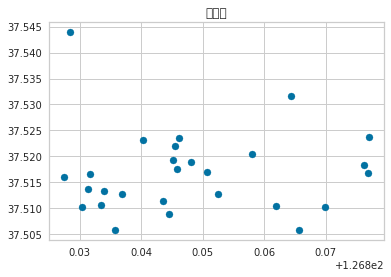

In [ ]:
visual_xy(geo_center, "양천구")

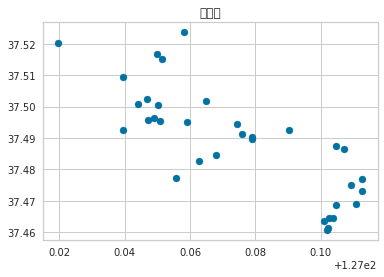

In [ ]:
visual_xy(geo_center, "강남구")

# 클러스터 정하기(pt. 2)


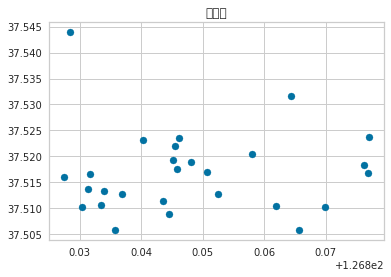

In [ ]:
visual_xy(geo_center, "양천구")

In [ ]:
geo_center.shape

(656, 5)

In [ ]:
#클러스터 변수 만들기

zero_array = np.zeros(656*1).reshape(-1, 1)
geo_center["cluster"] = zero_array
geo_center.head()
"""
xys = geo_center[geo_center["자치구"]=="양천구"][["x", "y"]]
model = KMeans(n_clusters = 3, random_state = 156)
model.fit(xys)
geo_center.loc[geo_center["자치구"] == "양천구", "cluster"] = model.fit_predict(xys)
geo_center[geo_center["자치구"] == "양천구"]
"""

'\nxys = geo_center[geo_center["자치구"]=="양천구"][["x", "y"]]\nmodel = KMeans(n_clusters = 3, random_state = 156)\nmodel.fit(xys)\ngeo_center.loc[geo_center["자치구"] == "양천구", "cluster"] = model.fit_predict(xys)\ngeo_center[geo_center["자치구"] == "양천구"]\n'

In [ ]:
"""
i=1
spec_gu = geo_center[geo_center["자치구"]=="양천구"]
spec_gu
spec_gu.loc[spec_gu["cluster"] ==i, "x"]

#plt.scatter(geo_center.loc[geo_center["자치구"] == "양천구", "x"], geo_center.loc[geo_center["자치구"] == "양천구", "y"], label = "cluster" +str(i))
"""
geo_center.head()

,자치구,field1,geometry,x,y,cluster
0,노원구,섬밭로 201 하계동 시영아파트,POINT (127.06629 37.63309),127.066294,37.633086,0.0
1,마포구,월드컵로 207 성산동 도시개발공사성산아파트,POINT (126.90148 37.56462),126.901477,37.564623,0.0
2,중랑구,용마산로 228 면목동 도시개발아파트,POINT (127.08841 37.57357),127.088409,37.573566,0.0
3,노원구,노원로19길 31 중계동 목화아파트,POINT (127.07005 37.64257),127.070051,37.642573,0.0
4,노원구,노원로 331 중계동 시영3단지목련아파트,POINT (127.06881 37.64593),127.068807,37.645926,0.0


In [ ]:
def make_cluster(df, k, gu, visualize = False, elbow = True):
  spec_gu = df[df["자치구"] == gu]
  xys = spec_gu[["x", "y"]]

  model = KMeans(n_clusters = k, random_state = 10)
  model.fit(xys)
  df.loc[df["자치구"] == gu, "cluster"] = model.fit_predict(xys)
  cluster_center = model.cluster_centers_

  
  if visualize:
    plt.figure(figsize = (8, 8))
    for i in range(k):
      
      plt.scatter(spec_gu.loc[spec_gu["cluster"] == i, "x" ], spec_gu.loc[spec_gu["cluster"] == i, "y"], label = "cluster"+str(i))
    plt.legend()
    plt.title("K = %d results" %k, size = 15)
    plt.xlabel("x", size = 6)
    plt.ylabel("y" , size = 6)
    plt.show()

    if elbow:
      visualizer = KElbowVisualizer(model, k = (1, 10))
      visualizer.fit(xys)

      return df, cluster_center


    else:
      print("elbow 없이 visualizing을 어떻게 합니까..")
      
      return df, cluster_center
      

  else:
    if elbow:
      visualizer = KElbowVisualizer(model, k =(1, 10))
      visualizer.fit(xys)

      return df, cluster_center





    else: 

      return df, cluster_center


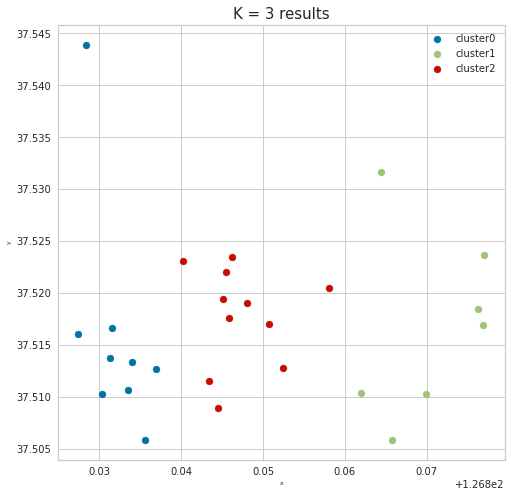

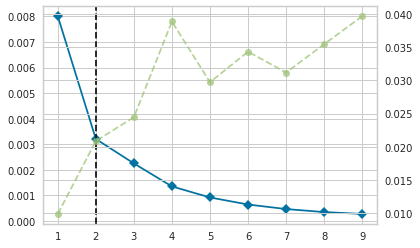

In [ ]:
new_df, center = make_cluster(geo_center, 3, "양천구", visualize = True, elbow = True)

In [ ]:
center

array([[126.83214743,  37.51589303],
       [126.87029379,  37.51673861],
       [126.84729571,  37.51774295]])

In [ ]:
gu_count

# 분배 인원 정하기

클러스터 동들 알려주었을 때 그 동들별 인원 

In [ ]:
people.head()

,법정동코드,시군구명,읍면동명,계
0,1111010100,종로구,청운동,2339
1,1111010200,종로구,신교동,1381
2,1111010300,종로구,궁정동,199
3,1111010400,종로구,효자동,569
4,1111010500,종로구,창성동,436


In [ ]:
people.groupby("시군구명")["계"].sum()/people.groupby("시군구명")["계"].sum().sum()

시군구명
강남구     0.056116
강동구     0.048753
강북구     0.031177
강서구     0.060359
관악구     0.051590
광진구     0.035780
구로구     0.041743
금천구     0.024371
노원구     0.053481
도봉구     0.033083
동대문구    0.035714
동작구     0.040529
마포구     0.038618
서대문구    0.032309
서초구     0.042875
성동구     0.029829
성북구     0.045700
송파구     0.069865
양천구     0.046777
영등포구    0.039799
용산구     0.023201
은평구     0.049662
종로구     0.015022
중구      0.012775
중랑구     0.040871
Name: 계, dtype: float64

In [ ]:
"""
1. sh 좌표 알고 그거 별로 클러스터를 만든다
2. 정확한 좌표 클러스터를 동별 클러스터로 치환한다.  (좌표 -> 주소 맵핑을 통해)
3. 동별 인원 알고 있으니 비율 산정한다. 
"""

'\n1. sh 좌표 알고 그거 별로 클러스터를 만든다\n2. 정확한 좌표 클러스터를 동별 클러스터로 치환한다.  (좌표 -> 주소 맵핑을 통해)\n3. 동별 인원 알고 있으니 비율 산정한다. \n'

In [ ]:
#cluster_dict = {"강남구" : [["클러스터1", "역삼동", "삼성동", "세곡동"] , ["클러스터2", "수서동", "개포동"]], "강동구": ...}
#서울시 내 각 구별 인구 비율
def whole_compute_ratio(df):
  total = df.groupby("시군구명")["계"].sum().sum()
  ratio = df.groupby("시군구명")["계"].sum()/total
  return ratio

whole_compute_ratio(people)
  




시군구명
강남구     5.611619
강동구     4.875332
강북구     3.117720
강서구     6.035869
관악구     5.158991
광진구     3.578037
구로구     4.174327
금천구     2.437131
노원구     5.348079
도봉구     3.308302
동대문구    3.571397
동작구     4.052923
마포구     3.861802
서대문구    3.230854
서초구     4.287523
성동구     2.982869
성북구     4.570028
송파구     6.986521
양천구     4.677698
영등포구    3.979880
용산구     2.320080
은평구     4.966185
종로구     1.502172
중구      1.277546
중랑구     4.087115
Name: 계, dtype: float64

In [ ]:
#df 에 데이터 넘겨주고 dc에 앞에서 정한 클러스터 넘겨줌. 특정 구를 알려주면 그 구 내 클러스터들이 각각 어느정도 비율의 사람들이 있는지 알 수 있음(장애인 분포 결정을 위한 함수)

gu = ""
dc = {}
df = pd.DataFrame()
def ingu_compute_ratio(df, dc, gu):
  cluster_dc = {}
  d_list_cluster = dc[gu]
  for i in range(len(d_list_cluster)):
    in_cluster = d_list_cluster[i]
    number = 0
    for n, d in enumerate(in_cluster):
      if n == 0 :
        cluster_name = in_cluster[n]

      else:

      
        try: 
          number+=df[df["읍면동명"] ==d]["계"].values
        except:
          print("그런 동은 없습니다!")
          pass
    cluster_dc[cluster_name] = int(number)
  
  return cluster_dc
    



In [ ]:
#테스팅해보기
cluster_dict = {"강남구" : [["강남1", "역삼동", "삼성동", "세곡동"] , ["강남2", "수서동", "개포동"]]}
ingu_compute_ratio(people, cluster_dict, "강남구")

{'강남1': 129634, '강남2': 83995}

array([86294])

# 구별 인원, 등급별 퍼센트 주어졌을 때 클러스터에 일괄적으로 배분할 수 있어야 함. 

In [ ]:
#시나리오: a 구에는 클러스터가 3개 있다. 그 클러스터별 인구 

# 미완성(딱히 볼 필요 없음)

In [ ]:

geo_center.crs
#epsg 4326 좌표계

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
geo_center = geo_center.to_crs({"init": "epsg:5179"})

geo_center.crs
#seoul_geo = seoul_geo.to_crs({"init": "EPSG:4326"})
#seoul_geo
#seoul_geo.crs

<Derived Projected CRS: +init=epsg:5179 +type=crs>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
seoul_geo.crs

<Derived Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich